In [439]:
import h5py
import numpy as np
from scipy.stats import linregress
from scipy.optimize import curve_fit

EPSILON = 8

np.set_printoptions(threshold=np.inf)
#c57
#ACTIVE TRIAL
filenames =[
"./C1_R1v2_ID1v2.mp4.predictions.000_C1_R1v2_ID1v2.analysis_fixed.h5",
"./C1_R1v4_ID1v3.mp4.predictions.000_C1_R1v4_ID1v3.analysis_fixed.h5",
"./C2_R1v2_ID1v3.mp4.predictions.000_C2_R1v2_ID1v3.analysis_fixed.h5",
"./C2_R4v1_ID4v1.mp4.predictions.000_C2_R4v1_ID4v1.analysis_fixed.h5",
"./C3_R2v1_ID3v4.mp4.predictions.000_C3_R2v1_ID3v4.analysis_fixed.h5",
"./C3_R1v4_ID4v1.mp4.predictions.000_C3_R1v4_ID4v1.analysis_fixed.h5",
'./C4_R2v1_ID3v2.mp4.predictions.000_C4_R2v1_ID3v2.analysis_fixed.h5',
"./C4_R1v4_ID2v4.mp4.predictions.000_C4_R1v4_ID2v4.analysis_fixed.h5",
"./C5_R2v1_ID2v4.mp4.predictions.000_C5_R2v1_ID2v4.analysis_fixed.h5",
"./C5_R4v1_ID3v4.mp4.predictions.000_C5_R4v1_ID3v4.analysis_fixed.h5",
"./C6_R1v2_ID1v3.mp4.predictions.slp.000_C6_R1v2_ID1v3.analysis_fixed.h5",
"./C6_R4v1_ID4v1.mp4.predictions.000_C6_R4v1_ID4v1.analysis_fixed.h5"
]


def get_info(filename):
    with h5py.File(filename, "r") as f:
        dset_names = list(f.keys())
        locations= f["tracks"][:].T
        node_names= [n.decode() for n in f["node_names"][:]]
        track_names= [n.decode() for n in f["track_names"][:]]

        MOUSE_YELLOW_PAGES = dict()

        for i, name in enumerate(track_names):
        # it is how you find their number, get it?
        # index to ID, eg: '2.4' -> 0
            MOUSE_YELLOW_PAGES[name] = i

        rank_dict = {}
        print(filename)
        for i in range(len(filename)):
            if filename[i] == 'R':
                rank1 = filename[i+1]
                rank2 = filename[i+3] 
            if filename[i] =='D':
                m1 = filename[3] + '.' + filename[i+1]
                m2 = filename[3] + '.' +filename[i+3]
                rank_dict[rank1] = m1
                rank_dict[rank2] = m2
        return (dset_names, locations, node_names, track_names, rank_dict, MOUSE_YELLOW_PAGES)
#get_info("./C5_R4v1_ID3v4.mp4.predictions.000_C5_R4v1_ID3v4.analysis.h5")
#print("===filename===")
#print(filename)
#print()

#print("===HDF5 datasets===")
#print(dset_names)
#print()

#print("===locations data shape===")
#print(locations.shape)
#print()

#print("===nodes===")

#for i, name in enumerate(node_names):
#    print(f"{i}: {name}")
#print()


#print('ranks', rank_dict)

#to do
make class match that takes in a filename and gives you 
self attributes: nodes, mice, ranks
and has functions that give you
1) winner
2) trial length
3) time in contact
4) time in push
5) total distance traveled

In [381]:
tube = "./tube_nodes.h5"
dset_names, locations, node_names, track_names, rank_dic = get_info(tube)

node_names
new_data = locations[~np.isnan(locations)]
new_data

./tube_nodes.h5


array([ 251.52263374, 1685.59670782,  796.70781893,  808.55967078])

In [380]:
track_names


[]

In [244]:
from scipy.interpolate import interp1d

class Match:
    def __init__(self, filename): 
        self.filename = filename

        with h5py.File(filename, "r") as f:
            dset_names = list(f.keys())
            locations = f["tracks"][:].T
            node_names = [n.decode() for n in f["node_names"][:]]
            track_names = [n.decode() for n in f["track_names"][:]]

            
            for i in range(len(filename)):
                if filename[i] == 'C':
                    cage = filename[i+1]
                if filename[i] == 'R':
                    rank1 = filename[i+1]
                    rank2 = filename[i+3] 
                if filename[i] =='D':
                    m1 = cage + '.' + filename[i+1]
                    m2 = cage + '.' +filename[i+3]
                    rank_dict[rank1] = m1
                    rank_dict[rank2] = m2

            self.locations_shape = locations.shape
            self.nodes = node_names
            self.mice = track_names
            self.ranks = rank_dict
            
            if cage > 4:
                self.strain = 'C57'
            else:
                self.strain = 'CD1'


            MOUSE_YELLOW_PAGES = dict()
            print("===Mouse IDs===")
            for i, name in enumerate(track_names):
                print(f"{i}: {name}")
                # it is how you find their number, get it?
                # index to ID, eg: '2.4' -> 0
                MOUSE_YELLOW_PAGES[name] = i

            EAR_INDEX = 0
            NOSE_INDEX = 1
            TAILBASE_INDEX = 2
            THORAX_INDEX = 3
            FRONT_FOOT_INDEX = 4
            REAR_FOOT_INDEX = 5




            ear_loc = locations[:, EAR_INDEX, :, :]
            nose_loc = locations[:, NOSE_INDEX, :,:]
            tail_loc = locations[:, TAILBASE_INDEX, :, :]
            thorax_loc = locations[:, THORAX_INDEX, :, :]    
            front_foot_loc = locations[:, FRONT_FOOT_INDEX, :, :]
            rear_foot_loc = locations[:, REAR_FOOT_INDEX, :, :]
            
    def fill_missing(Y, kind="linear"):
        
        """Fills missing values independently along each dimension after the first."""

        # Store initial shape.
        initial_shape = Y.shape

        # Flatten after first dim.
        Y = Y.reshape((initial_shape[0], -1))
        print (Y.shape)
        # Interpolate along each slice.
        # 7 mice, 2 dimensions (x,y), 5 nodes - 70 data for each frame
        for i in range(Y.shape[-1]):
            y = Y[:, i]
            print()
            print(f'iteration {i}, y shape {y.shape}')
            # Build interpolant.
            x = np.flatnonzero(~np.isnan(y))
            print(f'x shape: {x.shape}, y[x] shape: {y[x].shape}')
            f = interp1d(x, y[x], kind=kind, fill_value=np.nan, bounds_error=False)

            # Fill missing
            xq = np.flatnonzero(np.isnan(y))
            y[xq] = f(xq)
            
            # Fill leading or trailing NaNs with the nearest non-NaN values
            mask = np.isnan(y)
            y[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), y[~mask])

            # Save slice
            Y[:, i] = y

        # Restore to initial shape.
        Y = Y.reshape(initial_shape)
        return Y

    locations = fill_missing(locations)
    
    def get_winner():
        if nose_loc[1,0,0] > nose_loc[1,0,1]:
            left_mouse = 
        



frame count: 206
node count: 6
instance count: 2


In [424]:
from scipy.interpolate import interp1d

def fill_missing(Y, kind="linear"):
    
    """Fills missing values independently along each dimension after the first."""

    # Store initial shape.
    initial_shape = Y.shape

    # Flatten after first dim.
    Y = Y.reshape((initial_shape[0], -1))
    # Interpolate along each slice.
    # 7 mice, 2 dimensions (x,y), 5 nodes - 70 data for each frame
    for i in range(Y.shape[-1]):
        y = Y[:, i]
        # Build interpolant.
        x = np.flatnonzero(~np.isnan(y))
        f = interp1d(x, y[x], kind=kind, fill_value=np.nan, bounds_error=False)

        # Fill missing
        xq = np.flatnonzero(np.isnan(y))
        y[xq] = f(xq)
        
        # Fill leading or trailing NaNs with the nearest non-NaN values
        mask = np.isnan(y)
        y[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), y[~mask])

        # Save slice
        Y[:, i] = y

    # Restore to initial shape.
    Y = Y.reshape(initial_shape)
    return Y


In [396]:
#Visualize movement across video
EAR_INDEX = 0
NOSE_INDEX = 1
TAILBASE_INDEX = 2
THORAX_INDEX = 3
FRONT_FOOT_INDEX = 4
REAR_FOOT_INDEX = 5




ear_loc = locations[:, EAR_INDEX, :, :]
nose_loc = locations[:, NOSE_INDEX, :,:]
tail_loc = locations[:, TAILBASE_INDEX, :, :]
thorax_loc = locations[:, THORAX_INDEX, :, :]    
front_foot_loc = locations[:, FRONT_FOOT_INDEX, :, :]
rear_foot_loc = locations[:, REAR_FOOT_INDEX, :, :]

In [323]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

In [324]:
sns.set('notebook', 'ticks', font_scale=1.2)
mpl.rcParams['figure.figsize'] = [15,6]

In [418]:
def visualize_tracks(node, node_loc, mouse1, mouse2):
    """
    takes in 4 arguments: 
    node : string; node you want to visualize i.e. 'ear' or 'nose'
    node_loc : a [frames, 2] array
    mouse1 + mouse2 : string; ID name i.e. '1.2'
    returns two plots: locations (only x values) across time (frames) and tracks (all x vs y locations)
    """
    plt.figure()
    plt.plot(node_loc[:,0,MOUSE_YELLOW_PAGES[mouse1]], 'y',label=mouse1)
    plt.plot(node_loc[:,0,MOUSE_YELLOW_PAGES[mouse2]], 'g',label=mouse2)

    #y coordinates which we don't really need since its a more of a one dimensional movement were interested in
    #plt.plot(-1*front_loc[:,1,0], 'y')
    #plt.plot(-1*front_loc[:,1,1], 'g')

    plt.legend(loc="center right")
    plt.title(node + ' Locations')
    plt.savefig('./plots/tracks/id_{}vs{}locations_{}.png'.format(mouse1, mouse2, node))

    plt.figure(figsize=(7,7))
    plt.plot(node_loc[:,0,MOUSE_YELLOW_PAGES[mouse1]],node_loc[:,1,MOUSE_YELLOW_PAGES[mouse1]], 'y',label=mouse1)
    plt.plot(node_loc[:,0,MOUSE_YELLOW_PAGES[mouse2]],node_loc[:,1,MOUSE_YELLOW_PAGES[mouse2]], 'g',label=mouse2)
    plt.legend()

    #plt.xlim(0,1024)
    plt.xticks([])

    plt.ylim(0,1024)
    plt.yticks([])
    plt.title(node + ' tracks')
    plt.savefig('./plots/tracks/id_{}vs{}tracks_{}.png'.format(mouse1, mouse2, node))

visualize_tracks('nose', nose_loc, '2.4', '2.1')

KeyError: '2.4'

<Figure size 1080x432 with 0 Axes>

In [251]:
visualize_tracks('ear', ear_loc, '6.1', '6.3')

KeyError: '6.1'

<Figure size 1080x432 with 0 Axes>

KeyError: '1.2'

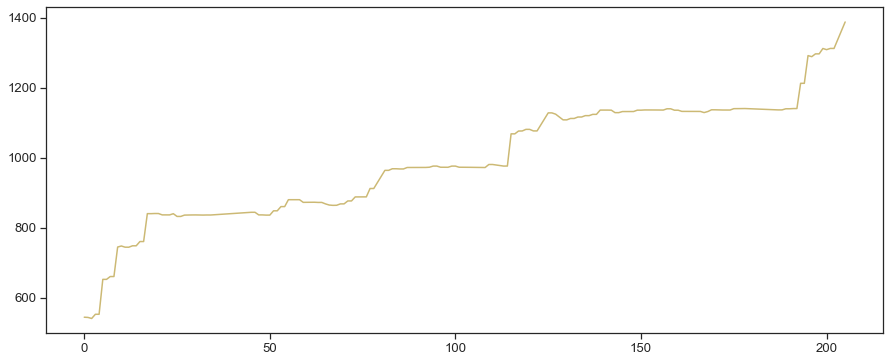

In [252]:
visualize_tracks('front foot', front_foot_loc, '1.1', '1.2')

In [325]:
from scipy.signal import savgol_filter

def smooth_diff(node_loc, win=25, poly=3):
    """
    node_loc is a [frames, 2] array
    
    win defines the window to smooth over
    
    poly defines the order of the polynomial
    to fit with
    
    """
    node_loc_vel = np.zeros_like(node_loc)
    
    for c in range(node_loc.shape[-1]):
        node_loc_vel[:, c] = savgol_filter(node_loc[:, c], win, poly, deriv=1)
    
    node_vel = np.linalg.norm(node_loc_vel,axis=1)
   

    return node_vel


In [326]:
import scipy.integrate as integrate
import scipy.special as special
vel = smooth_diff(thorax_loc[:,:,0])
distance_m1 = integrate.simpson(vel)
vel2 = smooth_diff(thorax_loc[:,:,1])
distance_m2 = integrate.simpson(vel2)
print(distance_m1, distance_m2)
#926, 766
#941, 779 



941.340078834219 779.9177544156785


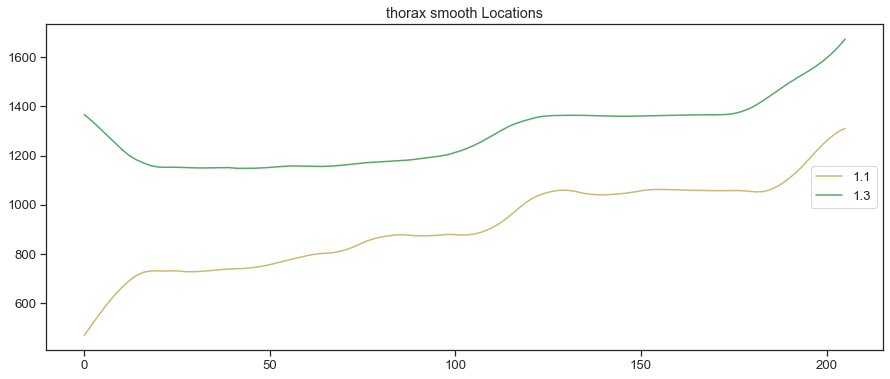

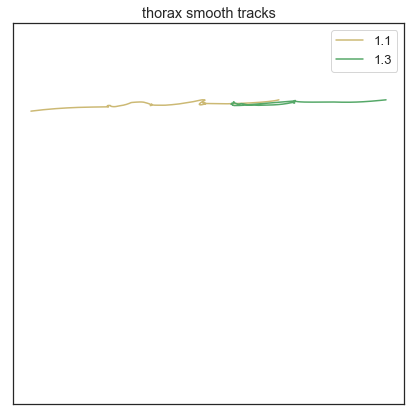

In [278]:
thorax_loc_smooth = np.zeros_like(thorax_loc)
thorax_loc_smooth[:,:,0] = smooth_pos(thorax_loc[:,:,0])
thorax_loc_smooth[:,:,1] = smooth_pos(thorax_loc[:,:, 1])
thorax_loc_smooth


visualize_tracks('thorax smooth', thorax_loc_smooth, '1.1', '1.3')

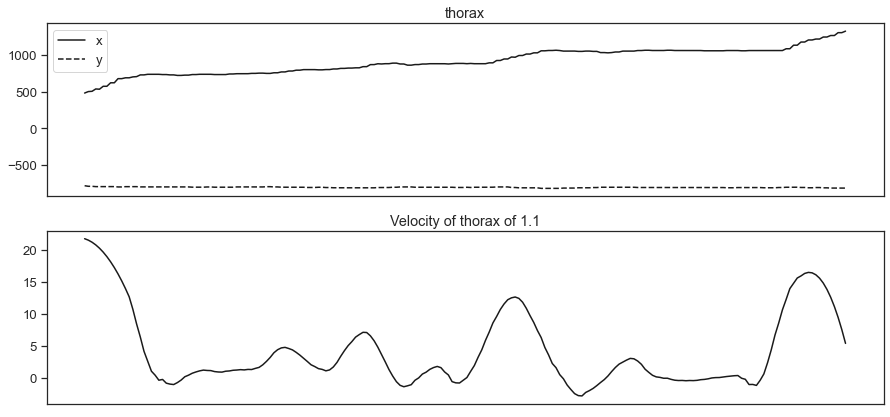

In [279]:
def visualize_velocity(node, node_loc, mouse):
    """
    node: string of node you want to visualize the velocity of i.e. 'nose'
    node_loc: a [frames, 2] array
    mouse: string, ID's i.e. '1.1'
    returns and saves plots of velocity visualization into velocity folder

    """
    node_vel = smooth_diff(node_loc[:, :, MOUSE_YELLOW_PAGES[mouse]])
    fig = plt.figure(figsize=(15,7))
    ax1 = fig.add_subplot(211)
    ax1.plot(node_loc[:, 0, MOUSE_YELLOW_PAGES[mouse]], 'k', label='x')
    ax1.plot(-1*node_loc[:, 1, MOUSE_YELLOW_PAGES[mouse]], 'k', label='y', linestyle='dashed')

    ax1.legend()
    ax1.set_xticks([])
    ax1.set_title(node)

    ax2 = fig.add_subplot(212, sharex=ax1)
    ax2.plot(node_vel[:,0], 'k')
    #ax2.imshow(node_vel[:,np.newaxis].T, aspect='auto', vmin=0, vmax=10)
    #ax2.set_yticks([])
    ax2.set_title('Velocity of ' + node + ' of ' + mouse)
    plt.savefig('./plots/velocity/id_{}_velocity_{}.png'.format(mouse, node))
visualize_velocity('thorax', thorax_loc, '1.1')

In [226]:
def plot_vel_tracks(node, node_loc, mouse):
    mouse_number = MOUSE_YELLOW_PAGES[mouse]
    fig = plt.figure(figsize=(15,6))
    ax1 = fig.add_subplot(121)
    ax1.plot(node_loc[:, 0, mouse_number], node_loc[:, 1, mouse_number], 'k')
    #ax1.set_xlim(0,1024)
    ax1.set_xticks([])
    ax1.set_ylim(0,1024)
    ax1.set_yticks([])
    ax1.set_title('Front Shoulder tracks')

    node_vel = smooth_diff(node_loc[:, :, MOUSE_YELLOW_PAGES[mouse]])   # use thx_vel_fly1 for other fly
    vmin = 0
    vmax = 10

    ax2 = fig.add_subplot(122)
    ax2.scatter(node_loc[:,0,mouse_number], node_loc[:,1,mouse_number], c=node_vel, s=4, vmin=vmin, vmax=vmax)
    #ax2.set_xlim(0,1024)
    
    ax2.set_xticks([])
    ax2.set_ylim(0,1024)
    ax2.set_yticks([])
    ax2.set_title(node+ ' tracks colored by velocity of ' + mouse)

plot_vel_tracks('nose', nose_loc, '6.1')



KeyError: '6.1'

NameError: name 'front_loc' is not defined

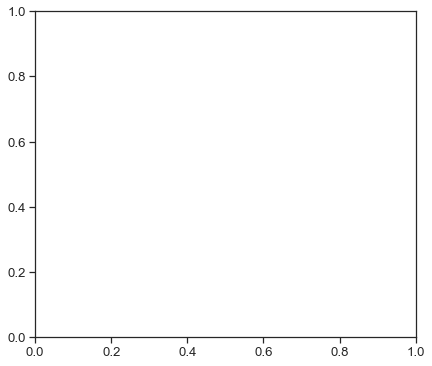

In [228]:
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(121)
ax1.plot(front_loc[:, 0, 1], front_loc[:, 1, 1], 'k')
ax1.set_xlim(0,1024)
ax1.set_xticks([])
ax1.set_ylim(0,1024)
ax1.set_yticks([])
ax1.set_title('Front Shoulder tracks')

kp = front_vel_mouse2_1  # use thx_vel_fly1 for other fly
vmin = 0
vmax = 10

ax2 = fig.add_subplot(122)
ax2.scatter(front_loc[:,0,1], front_loc[:,1,1], c=kp, s=4, vmin=vmin, vmax=vmax)
ax2.set_xlim(0,1024)
ax2.set_xticks([])
ax2.set_ylim(0,1024)
ax2.set_yticks([])
ax2.set_title('Front Shoulders tracks colored by magnitude of mouse 2.1 speed')

In [229]:
import pandas as pd

def corr_roll(datax, datay, win):
    """
    datax, datay are the two timeseries to find correlations between
    
    win sets the number of frames over which the covariance is computed
    
    """
    
    s1 = pd.Series(datax)
    s2 = pd.Series(datay)
    
    return np.array(s2.rolling(win).corr(s1))

In [230]:
win = 50

cov_vel = corr_roll(front_vel_mouse2_4, front_vel_mouse2_1,win)

fig, ax = plt.subplots(2, 1, sharex=True, figsize=(15,6))
ax[0].plot(front_vel_mouse2_4, 'y', label='Mouse-2.4')
ax[0].plot(front_vel_mouse2_1, 'g', label='Mouse-2.1')
ax[0].legend()
ax[0].set_title('Forward Velocity')
#what is "forward" velocity? when one goes forward the other goes backward? 

ax[1].plot(cov_vel, 'c', markersize=1)
ax[1].set_ylim(-1.2, 1.2)
ax[1].set_title('Covariance')

fig.tight_layout()

NameError: name 'front_vel_mouse2_4' is not defined

# to do 
function for contact
    given two arrays of x values, for nose nodes for m1 and m2, is there contact in each frame, returns an array with boolean (true false) for each frame true = contact
function for visualization 
    given two x location arrays, shows when they are in contact (color change of line) in a track trace, x axis = index = time/frame, y axis is displacement (so left mouse starts at bottom (zero) and right mouse starts at max displacement, distance between tracks should be small for contact )
use contact to define push 
use timeline to define push back vs push
use number of push backs to categorize trial as active or passive 
define retreat 
calculate trial length 

./C2_R4v1_ID4v1.mp4.predictions.000_C2_R4v1_ID4v1.analysis_fixed.h5
['ear', 'nose', 'tail_base', 'thorax', 'front_foot', 'rear_foot']
['2.1', '2.4']
CONTACT TEST
LEFT MOUSE IS MOUSE 2
{0: False, 1: False, 2: False, 3: False, 4: False, 5: False, 6: False, 7: False, 8: False, 9: False, 10: False, 11: False, 12: False, 13: False, 14: False, 15: False, 16: False, 17: False, 18: False, 19: False, 20: False, 21: False, 22: False, 23: False, 24: False, 25: False, 26: False, 27: False, 28: False, 29: False, 30: False, 31: False, 32: False, 33: False, 34: False, 35: False, 36: False, 37: True, 38: False, 39: False, 40: False, 41: False, 42: False, 43: False, 44: False, 45: False, 46: False, 47: False, 48: False, 49: False, 50: False, 51: False, 52: False, 53: False, 54: False, 55: False, 56: False, 57: False, 58: False, 59: False, 60: False, 61: False, 62: False, 63: False, 64: False, 65: False, 66: False, 67: False, 68: False, 69: False, 70: False, 71: False, 72: False, 73: False, 74: False, 7

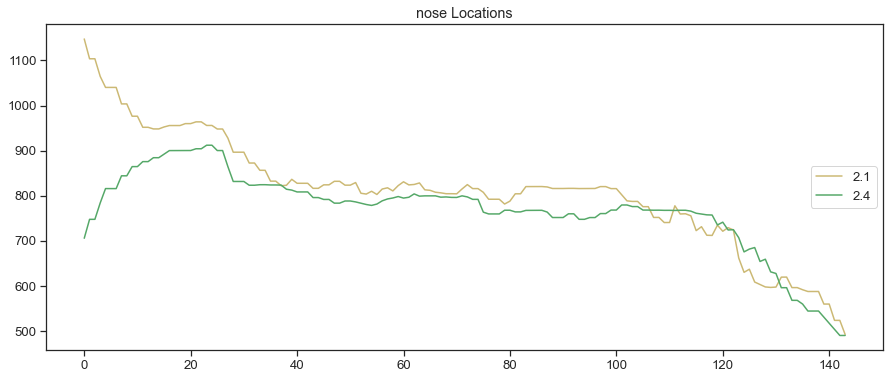

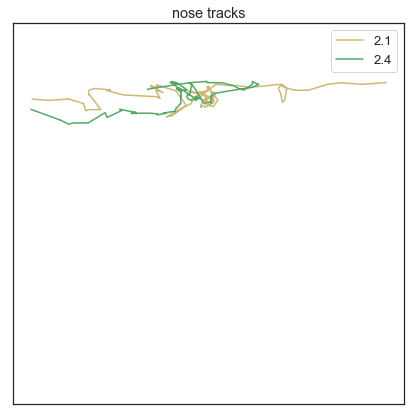

In [435]:
def contact(node_array_m1, node_array_m2, epsilon):
    """
    given two node location arrays for mouse 1 and mouse 2 in one dimension,
    nose nodes recommended for tube test in the x dimension, 
    returns a boolean of the number of frames of the trial/video
    true = contact, false = no contact
    epsilon = threshold for closeness that defines a contact
    """
    contact_array = [0] * len(node_array_m1)
      #get left mouse
      #left of screen in 0 on x axis
    if node_array_m1[0] > node_array_m2[0]:
        left_array = node_array_m2
        right_array = node_array_m1
        print('LEFT MOUSE IS MOUSE 2')
    else: 
        left_array = node_array_m1
        right_array = node_array_m2
        print('LEFT MOUSE IS MOUSE 1')
    for i in range(len(node_array_m1)):
        if abs(node_array_m1[i] - node_array_m2[i]) < epsilon:
            contact_array[i] = True
        if left_array[i] > right_array [i]:
            contact_array[i] = True
        else: 
            contact_array[i] = False
    return contact_array
        
dset_names, locations, node_names, track_names, rank_dict, MOUSE_YELLOW_PAGES = get_info("./C2_R4v1_ID4v1.mp4.predictions.000_C2_R4v1_ID4v1.analysis_fixed.h5")
locations = fill_missing(locations)
print(node_names)
print(track_names)
NOSE_INDEX = 1
nose_loc = locations[:, NOSE_INDEX, :,:]
print("CONTACT TEST")
contact_array = contact(nose_loc[:,0,0], nose_loc[:,0,1], 10)
contact_dict = {}
for i in range(len(contact_array)):
    contact_dict[i] = contact_array[i]
print(contact_dict)
visualize_tracks('nose', nose_loc, '2.1','2.4')
#nose_m1 = nose_loc[:,0,MOUSE_YELLOW_PAGES['1.1']]
#nose_m2 = nose_loc[:,0,MOUSE_YELLOW_PAGES['1.3']]
#thorax_m1 = thorax_loc[:,0, MOUSE_YELLOW_PAGES['6.1']]
#thorax_m2 = thorax_loc[:,0,MOUSE_YELLOW_PAGES['6.3']]

#contact(nose_m1, nose_m2,1)


def contact_visualization(node_array_m1, node_array_m2, epsilon):
    contact_array = contact(node_array_m1, node_array_m2, epsilon)
    con_col = [0] * len(contact_array)
    for i in range(len(contact_array)):
        if contact_array[i] == True:
            con_col[i] = 'r'
        else:
            con_col[i] ='k'
    print(con_col)


    plt.figure(figsize=(7,7))
    for i in range(len(node_array_m1)):
        if i%4 == 0:
            plt.scatter(i, node_array_m1[i], c=con_col[i], marker=".")
            plt.scatter(i, node_array_m2[i], c=con_col[i], marker="+")

    #plt.legend()

    #plt.xlim(0,len(node_array_m1))
    #plt.xticks([])

    #max_1 = max(node_array_m1)
    #max_2 = max(node_array_m2)
    #y_max = max(max_1,max_2)

    #plt.ylim(0,y_max)
    #plt.yticks([])
    plt.title('Contact')

#contact_visualization(nose_m1, nose_m2, 8)



['k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k',

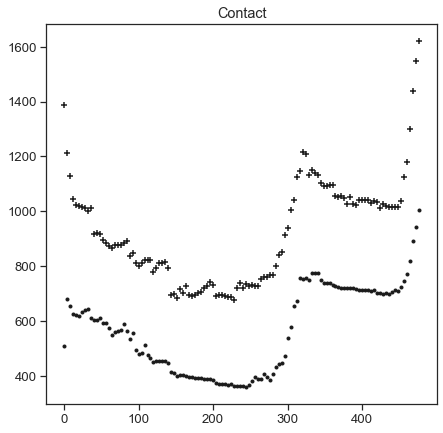

In [233]:
contact_visualization(thorax_m1, thorax_m2, 8)

In [236]:
contact_array = contact(nose_m1, nose_m2, EPSILON)
grads = np.gradient(nose_m1)*contact_array
print(np.where(grads > 0, grads, False))


ValueError: operands could not be broadcast together with shapes (206,) (220,) 

In [237]:
#def is_push(node_array_m1, node_array_m2, epsilon, win):
    '''
    node_array_m1: an array of x locations for a single mouse
    node_array_m2: same as above, for a mouse starting at the opposite end
    epsilon: slopes are only calculated when they are greater than epsilon
    win: the size of the window over which to calculate the slope
    A push happens when the mouse are in contact and moving
    This is calculated by looking at the slope inside a moving window * contact
    '''

    #contact_array = contact(node_array_m1, node_array_m2, epsilon)

    #for i in range(len(node_array_m1)):


IndentationError: expected an indented block (2990339737.py, line 13)

In [441]:
from audioop import avg
from dis import dis
from math import dist
# conversion factor = 1434 pixels/30.5 cm

match_count = 0
tube_test_df = pd.DataFrame(columns = ["Match", "Thorax Distance M1", "Average Velocity M1", "Thorax Distance M2", "Average Velocity M2", 'Trial Length', 'Total Contact Time', 'Percent Contact Time'])
for filename in filenames:
    info = []
    #for each video, extract data
    dset_names, locations, node_names, track_names, rank_dict, MOUSE_YELLOW_PAGES = get_info(filename)
    match = filename[2:15]
    info.append(match)
    #fill in the missing locations
    locations = fill_missing(locations)
    EAR_INDEX = 0
    NOSE_INDEX = 1
    TAILBASE_INDEX = 2
    THORAX_INDEX = 3
    FRONT_FOOT_INDEX = 4
    REAR_FOOT_INDEX = 5
    ear_loc = locations[:, EAR_INDEX, :, :]
    nose_loc = locations[:, NOSE_INDEX, :,:]
    tail_loc = locations[:, TAILBASE_INDEX, :, :]
    thorax_loc = locations[:, THORAX_INDEX, :, :]    
    front_foot_loc = locations[:, FRONT_FOOT_INDEX, :, :]
    rear_foot_loc = locations[:, REAR_FOOT_INDEX, :, :]
    #calculate velocity 
    # DISTANCE TRAVELED of MOUSE 1
    #Thorax
    vel_thorax_m1 = smooth_diff(thorax_loc[:,:,0])
    print(vel_thorax_m1.shape)
    avg_vel_m1 = np.mean(vel_thorax_m1) * 30* 30.5 / 1434
    dist_thorax_m1 = integrate.simpson(vel_thorax_m1)
    #Nose
    #vel_nose_m1 = smooth_diff(nose_loc[:,:,0])
    #dist_nose_m1 = integrate.simpson(vel_nose_m1)
    info.append(dist_thorax_m1 * 30.5 / 1434)
    info.append(avg_vel_m1)
    # DISTANCE TRAVELED OF M2
    vel_thorax_m2 = smooth_diff(thorax_loc[:,:,1])
    avg_vel_m2 = np.mean(vel_thorax_m2) * 30 * 30.5 / 1434
    dist_thorax_m2 = integrate.simpson(vel_thorax_m2)
    #vel_nose_m2 = smooth_diff(nose_loc[:,:,0])
    #dist_nose_m2 = integrate.simpson(vel_nose_m2)
    info.append(dist_thorax_m2  * 30.5 / 1434)
    info.append(avg_vel_m2)
    # Trial length = number of frames
    trial_length = locations.shape[0] 
    info.append(trial_length/ 30)
    contact_array = contact(nose_loc[:,0,0], nose_loc[:,0,1], 10)
    print(len(contact_array))
    contact_total = 0
    for i in range(len(contact_array)):
        if contact_array[i] == True:
            contact_total += 1
        else:
            pass
    info.append(contact_total/30)
    percent_contact = contact_total/trial_length
    info.append(percent_contact)
    tube_test_df.loc[match_count] = info
    match_count += 1
tube_test_df
tube_test_df.to_excel('tubetest_sleap_analysis.xlsx')

./C1_R1v2_ID1v2.mp4.predictions.000_C1_R1v2_ID1v2.analysis_fixed.h5
(1213,)
LEFT MOUSE IS MOUSE 1
1213
./C1_R1v4_ID1v3.mp4.predictions.000_C1_R1v4_ID1v3.analysis_fixed.h5
(206,)
LEFT MOUSE IS MOUSE 1
206
./C2_R1v2_ID1v3.mp4.predictions.000_C2_R1v2_ID1v3.analysis_fixed.h5
(775,)
LEFT MOUSE IS MOUSE 1
775
./C2_R4v1_ID4v1.mp4.predictions.000_C2_R4v1_ID4v1.analysis_fixed.h5
(144,)
LEFT MOUSE IS MOUSE 2
144
./C3_R2v1_ID3v4.mp4.predictions.000_C3_R2v1_ID3v4.analysis_fixed.h5
(773,)
LEFT MOUSE IS MOUSE 2
773
./C3_R1v4_ID4v1.mp4.predictions.000_C3_R1v4_ID4v1.analysis_fixed.h5
(277,)
LEFT MOUSE IS MOUSE 1
277
./C4_R2v1_ID3v2.mp4.predictions.000_C4_R2v1_ID3v2.analysis_fixed.h5
(407,)
LEFT MOUSE IS MOUSE 1
407
./C4_R1v4_ID2v4.mp4.predictions.000_C4_R1v4_ID2v4.analysis_fixed.h5
(59,)
LEFT MOUSE IS MOUSE 2
59
./C5_R2v1_ID2v4.mp4.predictions.000_C5_R2v1_ID2v4.analysis_fixed.h5
(415,)
LEFT MOUSE IS MOUSE 1
415
./C5_R4v1_ID3v4.mp4.predictions.000_C5_R4v1_ID3v4.analysis_fixed.h5
(57,)
LEFT MOUSE IS MOU